# Injecting comets into our lightcurves

This short notebook shows how to inject fake signals in lightcurves. This project is looking for comets, so we are injecting comet shapes. For other shapes, the only difference is the functions you create to make those shapes.

## Importing libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

os.chdir("../")
from scripts.analysis_tools_cython import (
    import_XRPlightcurve,
    normalise_flux,
    processing,
    comet_curve,
)
from astropy.table import Table

In [2]:
plt.rcParams["figure.figsize"] = (10, 6)

### Importing a lightcurve where there is no known exocomet

In [3]:
data, lc_info = import_XRPlightcurve(
    "betapic/xrp/tesslcs_sector_7_104_2_min_cadence_targets_tesslc_270577175.pkl",
    sector=5,
    drop_bad_points=True,
)

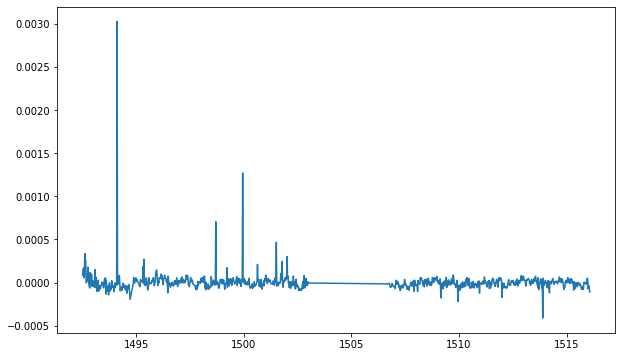

In [4]:
plt.plot(data["time"], normalise_flux(data["corrected flux"]))
plt.show()

## Comet injection
The source code has some pre-defined functions for comet shapes. We have the `comet_curve` function which assumes a forward-moving comet. For several reasons (namely the ability to ensure we capture the asymmetry on both sides of the transit), we use the `skewed_gaussian` function in our actual search run to fit comet models, but for the sake of injection recovery, these comet shapes are fine. 

In [5]:
def inject_comet(flux, time, depth, injected_time):
    return flux * (
        1 - comet_curve(time, depth, injected_time, 3.02715600e-01, 3.40346173e-01)
    )

We inject in logspace because we would be able to show percent change or change in multiplicative factors.

In [6]:
depth = 10 ** np.random.uniform(-4, -2)
new_flux = inject_comet(data["corrected flux"], data["time"], depth, 1510)

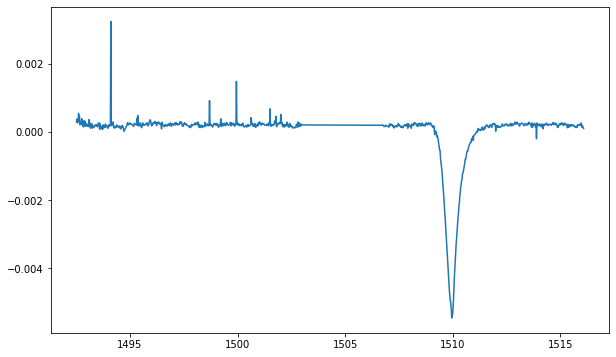

In [7]:
plt.plot(data["time"], normalise_flux(new_flux))

Comet is injected! Now, we can run the search and see if this comet is recovered. The bulk of the search happens with the `processing` function from `analysis_tools_cython`.

- Since `processing` requires the data to be a 4-column table format, we'll create this first and run our search.

### Processing

In [9]:
table = Table()
table["time"] = data["time"]
table["flux"] = new_flux
table["quality"] = data["quality"]
table["flux_error"] = data["flux error"]

In [26]:
results, _ = processing(table, ".", lc_info=lc_info, method="median")

In [27]:
results = results.split()
time = results[3]

In [28]:
time

'1509.94956411'

We recovered the comet we injected.

In some cases, we will not recover these injected comets. Since the comet depths will be random, it is possible that there are other signals that are larger than these comets. Our search algorithm only caters for the largest transit in a lightcurve, hence those comet signals will not be recovered. Another case is that the noise of the lightcurve would simply be too noisy for to recover the comet transit. Remember that typical comet transits are very low in amplitude (~ 2mmag), therefore in fainter magnitudes it is more likely than not we will not be able to recover these transits. The star in this example, Beta Pictoris, is super bright at `mag=3.8`. Therefore, noise would be quite minimal in this aperture.